In [9]:
import numpy as np
from scipy.signal import find_peaks
from astropy import constants, units
import numpy as np
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter as svg

from astropy.timeseries import LombScargle
from astropy import constants, units
from scipy.signal import find_peaks

In [10]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    #bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux

In [3]:
'''
Using numpy fourier transform
'''

def vsini(wave, flux, epsilon=0.6, clam=None, window=None):
    cc = constants.c.to(units.AA / units.s).value

    if window is not None:
        keep = (window[0] <= wave) & (wave <= window[1])
        wave, flux = wave[keep], flux[keep]

    clam = clam or np.mean(wave)

    q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

    freqs, ampls = np.fft.fftfreq(len(wave), 0.05), np.abs(np.fft.fft(1 - flux))
    ampls /= max(ampls)

    peaks, _ = find_peaks(-ampls)
    minima = freqs[peaks][:-1]
    minvals = ampls[peaks][:-1]

    freqs = freqs * clam / q1 / cc
    vsini_values = cc / clam * q1 / minima

    error = np.ptp(wave) * clam / q1 / cc

    return (freqs, ampls), (minima, minvals), vsini_values/10**13, error

In [51]:
'''
using astropy oversampled lomb scargle
'''

def vsini(wave, flux, epsilon=0.0, clam=None, window=None):
    cc = constants.c.to(units.AA / units.s).value

    if window is not None:
        keep = (window[0] <= wave) & (wave <= window[1])
        wave, flux = wave[keep], flux[keep]

    clam = clam or np.mean(wave)

    q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

    # Using Lomb-Scargle periodogram instead of FFT
    frequency, power = LombScargle(wave, flux).autopower(samples_per_peak=50)

    power /= max(power)  # Normalize power for comparison with ampls

    # Find minima in the power spectrum
    peaks, _ = find_peaks(-power)
    minima = frequency[peaks][:-1]
    minvals = power[peaks][:-1]

    frequency = frequency * clam / q1 / cc
    vsini_values = cc / clam * q1 / minima

    # Estimate the error based on the wavelength range and scaling factor
    error = np.ptp(wave) * clam / q1 / cc

    return (frequency, power), (minima, minvals), vsini_values / 10**13, error

In [52]:
clam = 6678
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
result = vsini(wave, flux, clam = clam, window=[6670, 6686])
print('V(FT) is', max(result[2]), 'km/s')

V(FT) is 235.95904916050256 km/s


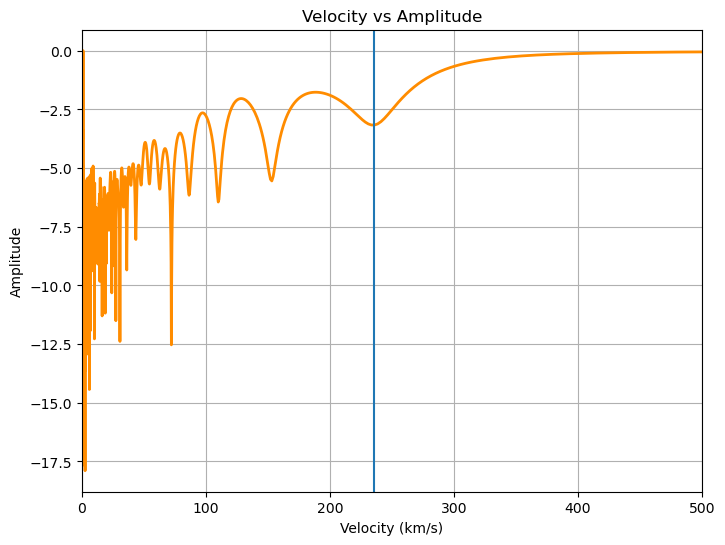

In [53]:

epsilon = 0.6
cc = constants.c.to(units.AA / units.s).value
q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4
freqs = result[0][0] /( clam / q1 / cc)
ampls = result[0][1]
def freq_to_velocity(freqs, clam, q1):
    cc = constants.c.to(units.AA / units.s).value
    return (cc / clam * q1 / freqs)/10**13

# Convert frequencies to velocities
velocities = freq_to_velocity(freqs, clam, q1)
log_ampls = np.log(ampls)


#svgol_freq = svg(log_ampls, window_length= 10, polyorder = 3, mode = 'interp')


# Plot velocity vs amplitude
plt.figure(figsize=(8, 6))
plt.plot(velocities, log_ampls, color = 'darkorange', linewidth = 2)
#plt.plot(velocities, svgol_freq, color = 'red')
plt.ylabel('Amplitude')
plt.xlabel('Velocity (km/s)')
plt.title('Velocity vs Amplitude')
plt.grid(True)
plt.xlim(0,500)
plt.axvline(max(result[2]))
plt.show()